# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline
# Load pickled data
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:4]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


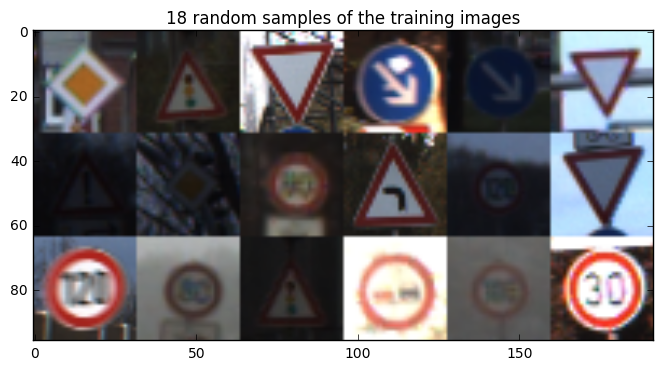

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

#Lets plot some random images
samples = np.zeros([3*32,6*32,3])
for i in range(3):
    for j in range(6):
        rimg=np.random.randint(n_train, size=1)
        samples[(i*32):((i+1)*32),(j*32):((j+1)*32),:] = X_train[rimg,:,:,:]
        
plt.figure(figsize=(10,4))
plt.imshow(samples/255,cmap="prism")
plt.title('18 random samples of the training images')

It can be seen from the histogram that some categories have more sample than others. It can be expected that the results are a bit unbalanced between categories because of this. But it can also be that some images are easier to categories based on special features, not only by number of samples. 

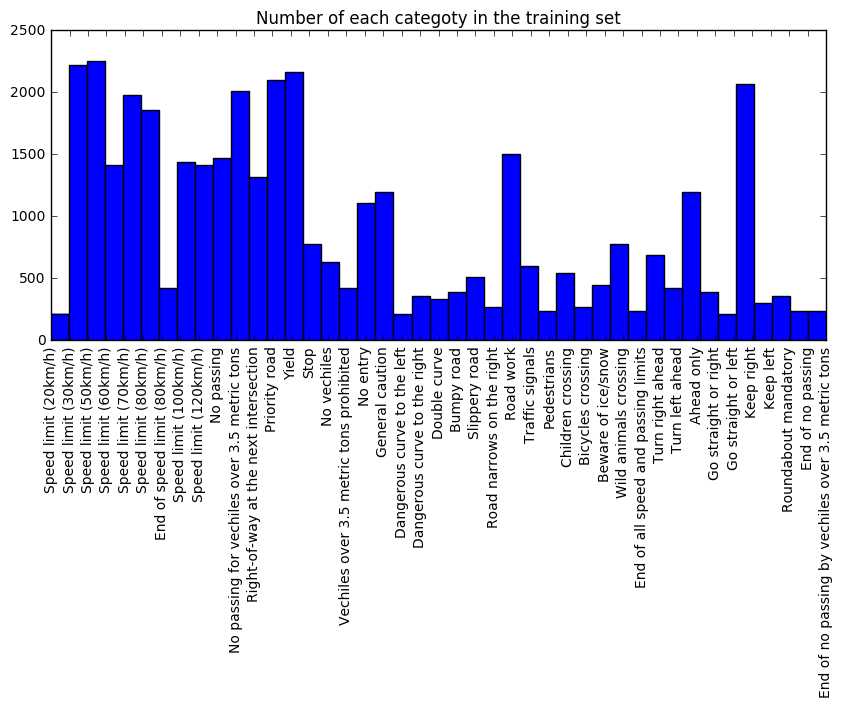

In [4]:
category_names=pd.read_csv('signnames.csv')
plt.figure(figsize=(10,4))
plt.hist(y_train,bins=43)
plt.axis([0, 42, 0, 2500])
plt.xticks(range(43),category_names['SignName'],rotation='vertical')
plt.title('Number of each categoty in the training set')

# Let's one hot encode the categories
one_hot_enc = LabelBinarizer()
one_hot_enc.fit(y_train)
y_train = one_hot_enc.transform(y_train)
y_test = one_hot_enc.transform(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

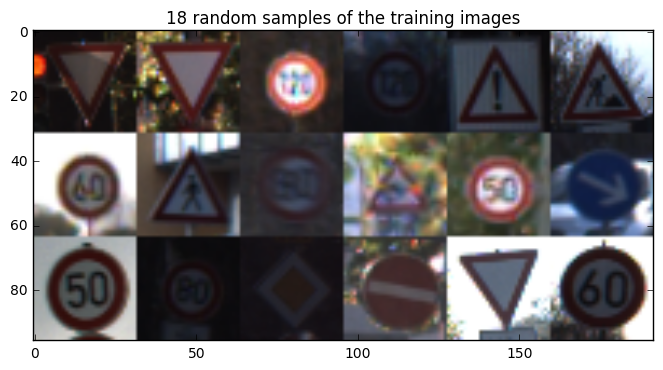

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#First, let's normalise the image data between 0...1
X_train_new = X_train / 255.
X_test_new = X_test / 255.

#Lets plot some random images
samples = np.zeros([3*32,6*32,3])
for i in range(3):
    for j in range(6):
        rimg=np.random.randint(n_train, size=1)
        samples[(i*32):((i+1)*32),(j*32):((j+1)*32),:] = X_train_new[rimg,:,:,:]

plt.figure(figsize=(10,4))
plt.imshow(samples)
plt.title('18 random samples of the training images')

In [6]:
# One hot encoding the output y
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [7]:
print('Initial number of training samples =',X_train.shape[0])

X_train, X_valid, y_train, y_valid = train_test_split(X_train_new,y_train,
                                                      test_size=0.2, 
                                                      random_state=10)
print('After split')
print('Training sample size =',X_train.shape[0])
print('Validation sample size =',X_valid.shape[0])

Initial number of training samples = 39209
After split
Training sample size = 31367
Validation sample size = 7842


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** The data is used very close to the original data. Input data is scaled to range 0 to 1 and the outputs are one hot encoded for the training. After this a validation set is separated from the training set by taking a random sample of 20% for validation

I experimented with grayscale images, but I chose to go with color to give the model some more data. Also I considered to generate data to balance the missing categories, but decided not to to save training time.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

# Input/Image
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]])
y = tf.placeholder(tf.float32, [None, n_classes])

# Network Parameters
keep_prob = tf.placeholder(tf.float32)

In [9]:
# Training Parameters
training_epochs = 150
batch_size = 128
dropout_rate = 0.45
learning_rate = 0.001

In [10]:
# network structure parameters
down_sample_factor = 2
n_full_connected_layer = 1024
n_full_connected_layer2 = 512

#Output depth
k_out = [32,64]
n_conv_layer = len(k_out)

#stride
stride = [[1,1,1,1],
          [1,1,1,1]]

#max pool down sampling
max_pool_k = [[1,down_sample_factor,down_sample_factor,1],
              [1,down_sample_factor,down_sample_factor,1]]

colour_channel = image_shape[2]

# Store layers weight & bias
k_fcl_in = image_shape[0]/(n_conv_layer*down_sample_factor) * image_shape[1]/(n_conv_layer*down_sample_factor) * k_out[-1]
k_fcl_in = int(k_fcl_in)

weights = {
    'c1': tf.Variable(tf.truncated_normal([5, 5, #filter size
                                           colour_channel,  #depth in
                                           k_out[0]],stddev=0.2)),  #depth out
    'c2': tf.Variable(tf.truncated_normal([5, 5, #filter size
                                           k_out[0],     #depth in
                                           k_out[1]],stddev=0.2)),  #depth out
    'fcl' : tf.Variable(tf.truncated_normal([k_fcl_in, 
                                             n_full_connected_layer],stddev=0.2)),
    'fcl2' : tf.Variable(tf.truncated_normal([n_full_connected_layer, 
                                          n_full_connected_layer2],stddev=0.2)),
    'out': tf.Variable(tf.truncated_normal([n_full_connected_layer, n_classes],stddev=0.2))
}
biases = {
    'c1': tf.Variable( tf.truncated_normal([k_out[0]],stddev=0.2) ),
    'c2': tf.Variable( tf.truncated_normal([k_out[1]],stddev=0.2) ),
    'fcl' :         tf.Variable( tf.truncated_normal([n_full_connected_layer],stddev=0.2) ),
    'fcl2' :         tf.Variable( tf.truncated_normal([n_full_connected_layer2],stddev=0.2) ),
    'out':          tf.Variable( tf.truncated_normal([n_classes],stddev=0.2) )
}

In [11]:
# Create some wrappers for simplicity
# from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb
def conv2d_maxpool2d(x, W, b, strides=[1,1,1,1], k_max_pool=[1,2,2,1]):
    # Conv2D wrapper, with bias and relu activation
    result = tf.nn.conv2d(x, W,
                          strides=strides, 
                          padding='SAME')
    result = tf.nn.bias_add(result, b)
    result = tf.nn.relu(result)
    result = tf.nn.max_pool(result, ksize=k_max_pool, 
                            strides=k_max_pool,
                            padding='SAME')
    return result

# Create model
def conv_net(x, weights, biases, dropout, max_pool_k, stride):
    # Convolution Layer and Max Pooling (down-sampling)
    conv1 = conv2d_maxpool2d(x, weights['c1'], biases['c1'], stride[0], k_max_pool=max_pool_k[0])
    # Convolution Layer and Max Pooling (down-sampling)
    conv2 = conv2d_maxpool2d(conv1, weights['c2'], biases['c2'], stride[1], k_max_pool=max_pool_k[1])
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['fcl'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['fcl']), biases['fcl'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    # Output, class prediction
    pred = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return pred

In [12]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob, max_pool_k, stride)
# Define loss and optimizer
softmax_logits = tf.nn.softmax_cross_entropy_with_logits(pred, y)
cost = tf.reduce_mean(softmax_logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [13]:
# To evaluate the model
def correct_pred_wrapper(pred, y):
    pred_class = tf.argmax(pred, 1)
    y_class = tf.argmax(y, 1)
    correct_pred = tf.equal(pred_class, y_class)
    elements_equal_to_value = tf.equal(correct_pred, True)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    tf.Print(count, [count], message="correct_pred count: ")
    return correct_pred

top5=tf.nn.top_k(tf.nn.softmax(pred), k=5, sorted=True, name=None)

correct_pred = correct_pred_wrapper(pred, y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Initializing the variables
init = tf.initialize_all_variables()
# The accuracy measured against the validation set
validation_accuracy = 0.0

print("Starting to train...")
# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(n_train/batch_size)
        # Loop over all batches
        for batch_i in range(total_batch):
            batch_start = batch_i*batch_size
            batch_end = min((batch_start+batch_size),n_train)
            batch_x = X_train[batch_start:batch_end]
            batch_y = y_train[batch_start:batch_end]
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_rate})
        # Check accuracy against Validation data
        validation_accuracy,loss = sess.run([accuracy,cost], feed_dict={x: X_valid, y: y_valid, keep_prob: 1.})
        print("Epoch: %s, "%epoch, "Validataion Accuracy: %s, "%validation_accuracy, "Loss: %s"%loss)
    print("Optimization Finished !")
    saver = tf.train.Saver()
    saver.save(sess, 'my-model')
    print("===========================")
    print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={x: X_test, y: y_test, keep_prob: 1.}))

Starting to train...
Epoch: 0,  Validataion Accuracy: 0.322112,  Loss: 2.48641
Epoch: 1,  Validataion Accuracy: 0.481765,  Loss: 1.91383
Epoch: 2,  Validataion Accuracy: 0.628156,  Loss: 1.27167
Epoch: 3,  Validataion Accuracy: 0.7266,  Loss: 0.878656
Epoch: 4,  Validataion Accuracy: 0.668962,  Loss: 1.33915
Epoch: 5,  Validataion Accuracy: 0.897475,  Loss: 0.340726
Epoch: 6,  Validataion Accuracy: 0.93267,  Loss: 0.215213
Epoch: 7,  Validataion Accuracy: 0.942999,  Loss: 0.188654
Epoch: 8,  Validataion Accuracy: 0.950778,  Loss: 0.161547
Epoch: 9,  Validataion Accuracy: 0.948738,  Loss: 0.166846
Epoch: 10,  Validataion Accuracy: 0.960724,  Loss: 0.1342
Epoch: 11,  Validataion Accuracy: 0.976664,  Loss: 0.0894119
Epoch: 12,  Validataion Accuracy: 0.968885,  Loss: 0.113611
Epoch: 13,  Validataion Accuracy: 0.950395,  Loss: 0.174478
Epoch: 14,  Validataion Accuracy: 0.947845,  Loss: 0.186251
Epoch: 15,  Validataion Accuracy: 0.961107,  Loss: 0.149638
Epoch: 16,  Validataion Accuracy: 0.9

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** Validation set is used during the training to keep an eye on the accuracy. The test set is only used at the end. No extra data was generated although it might be helpful to provide better accuracy when al th categories would be balanced.

For the optimizer I chose AdamOptimizer as it requires less fine tuning compared to GradienDecent.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The model consists of two convolution layers and one connected ReLu layer with dropout and an output layer.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** For the final model I used 150 training epochs and a batch size of 128
with a dropout of 0.45 and learning rate of 0.001. It is very likely that these are not the most optimum values as I selected the values based on epocs of 20 and when I was satisfied enough, I let the final version run 200 epochs.

Smaller learning rates were slow to converge and larger ones were not stable. The dropout range did not have too big of an effect to the results.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** Trial and error. I started with simple linear models and with the LeNet implementation provided with the course. However, I was not able to create a model that could provide an accuracy over 30%. After some time reading the forums and the web I found https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb. This gave me enough information to implement this version of the code. I have used Keras earlier as it is "simpler" than pure Tensorflow, so this was a bit of a struggle.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

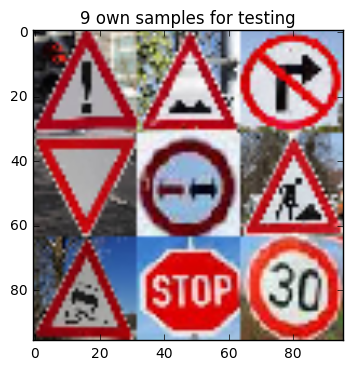

In [15]:
from PIL import Image
import os

mypath = "own_images/"
new_images = os.listdir(mypath) 

X_own = np.zeros([len(new_images),32,32,3])

i0=0
for i in new_images:
    img = Image.open(mypath+i)
    img = np.asarray(img.resize((32, 32)))
    X_own[i0]=img/255.
    i0 += 1

#Let's plot own images
samples = np.zeros([3*32,3*32,3])
i0=0
for i in range(3):
    for j in range(3):
        samples[(i*32):((i+1)*32),(j*32):((j+1)*32),:] = X_own[i0,:,:,:]
        i0 += 1
        
plt.figure(figsize=(10,4))
plt.imshow(samples,cmap="prism")
plt.title('9 own samples for testing')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** Quality of these images varies, but these images are quite clear to identify. There is a "No right turn" sign which does not have a category in the training set. Also the angles and offsets can cause problems. To fight this it could be possible to generate more balanced dataset with original images with small rotations and offsets.

In [16]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
sess_extra = tf.Session()
init = tf.initialize_all_variables()
sess_extra.run(init)
new_saver = tf.train.import_meta_graph('my-model.meta')
new_saver.restore(sess_extra, tf.train.latest_checkpoint('./'))

print(X_own.shape)
pred_own,top5 = sess_extra.run([pred,top5], feed_dict={x: X_own, keep_prob: 1.0})

(9, 32, 32, 3)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:** New pictures were collected from the internet. The model predicted 8 out of 9 signs corretly, as shown below. This is in the range what was to be expected with the accuracy level achieved in the training of the model. The validation accuracy was very high and can be slightly over fitted, but these results are close to it and even slightly better than on the test set (not counting the right turn sign).

In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
own_result = np.argmax(pred_own,axis=1)

for i in range(len(new_images)):
    print('Predicted  ',category_names['SignName'][own_result[i]])
    print('Known value',new_images[i][0:-4])

print(top5)

Predicted   General caution
Known value general_caution
Predicted   Bumpy road
Known value bumpy_road
Predicted   Priority road
Known value no_right_turn
Predicted   Yield
Known value yield
Predicted   No passing
Known value no_passing
Predicted   Road work
Known value road_work
Predicted   Slippery road
Known value slippery
Predicted   Stop
Known value stop
Predicted   Speed limit (30km/h)
Known value speed_limit_30
TopKV2(values=array([[  1.00000000e+00,   1.39636469e-33,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.15467061e-10,   1.21964092e-12,
          2.02473570e-14,   5.54360763e-17],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   9.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** Biggest uncertanties are in the 3rd and in the 7th sign. The 3rd sign does not appear in the categories, so it is understably difficult to categories.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** Tensorflows own saving and import models were used to save the trained model and to import the model to make own predictions. 

(tf.train.Saver() => tf.train.import_meta_graph)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.